# COVID-19 Brasil - Análise de Dados

## Conteúdo

O seguinte *notebook* é resultado de uma análise exploratória aos dados da COVID-19 no Brasil. Foram feitas várias observações e considerações sobre os dados.

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} nbformat
!conda install --yes --prefix {sys.prefix} plotly==4.6.0
!conda install --yes --prefix {sys.prefix} psutil requests
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} plotly-orca==1.2.1

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.



In [2]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.graph_objs import *
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "svg"

# Ler os dados
data = pd.read_csv('./data/brazil_covid19.csv')

## Definição das Variáveis


In [3]:
# Últimas 5 entradas do dataset
print("Tail do Dataset:\n", data.tail())

Tail do Dataset:
             date   region state   cases  deaths
2992  2020-06-14  Sudeste    RJ   79572    7672
2993  2020-06-14  Sudeste    SP  178202   10694
2994  2020-06-14      Sul    PR    9583     326
2995  2020-06-14      Sul    RS   14661     350
2996  2020-06-14      Sul    SC   13360     195


É de notar que este *dataset* contém os dados numa série temporal, ou seja, o número de casos num determinado dia é cumulativo.


Temos no total 5 variáveis:
- **date**: Representa a data (YYYY-MM-DD) para cada entrada, sendo que existem várias entradas com a mesma data, relativas a diferentes estados.
- **region**: Representa a região do país relativa ao estado, para cada entrada.
- **state**: Representa o estado brasileiro a que se refere cada entrada de dados.
- **cases**: Representa o nº de casos confirmados de infeção.
- **deaths**: Representa o nº de óbitos confirmados.

Apresenta-se a descrição das variáveis contínuas **cases** e **deaths**:

In [4]:
data.describe()

,cases,deaths
count,2997.000000,2997.000000
mean,6294.361361,365.082416
std,15893.539067,1109.462169
min,0.000000,0.000000
25%,16.000000,0.000000
50%,638.000000,21.000000
75%,4853.000000,168.000000
max,178202.000000,10694.000000


De seguida, são listados os valores possíveis para as nossas variáveis categóricas, que são respetivamente os nomes de todas as regiões e estados.

In [5]:
# Lista de regiões do dataset
print("\nRegions: ", data.region.unique())

# Lista de estados do dataset
print("\nStates: ", data.state.unique())


Regions:  ['Centro-Oeste' 'Nordeste' 'Norte' 'Sudeste' 'Sul']

States:  ['DF' 'GO' 'MS' 'MT' 'AL' 'BA' 'CE' 'MA' 'PB' 'PE' 'PI' 'RN' 'SE' 'AC'
 'AM' 'AP' 'PA' 'RO' 'RR' 'TO' 'ES' 'MG' 'RJ' 'SP' 'PR' 'RS' 'SC']


Como podemos ver, não existem quaisquer valores nulos para todas as 5 colunas do *dataset*. Logo não é necessário qualquer tratamento de dados extra.


In [6]:
# Verificar valores nulos
print("Null Values:\n", data.isnull().sum())

Null Values:
 date      0
region    0
state     0
cases     0
deaths    0
dtype: int64


## Análise Exploratória dos Dados

Neste capítulo são feitas algumas avaliações e visualizações analíticas acerca dos dados.

Começando pelo cálculo do nº de dias já passado, de modo a termos uma noção do período de tempo da análise.

In [7]:
# Nº de dias desde primeira entrada de dados
print("Number of Days Passed: ", data.date.unique().size)

Number of Days Passed:  111


In [8]:
# Primeiro caso de infeção
data[data['cases'] > 0].head(1)

,date,region,state,cases,deaths
50,2020-02-26,Sudeste,SP,1,0


O primeiro caso de infeção confirmado no país deu-se no dia 26 de fevereiro, mais precisamente no estado de São Paulo.

In [9]:
# Primeira morte
data[data['deaths'] > 0].head(1)

,date,region,state,cases,deaths
590,2020-03-17,Sudeste,SP,164,1


A primeira morte por infeção do vírus, foi confirmada no dia 17 de março, novamente no estado de São Paulo.

Foi feito o gráfico da curva epidemiológica do vírus ao longo deste perído de tempo, em termos de casos confirmados.

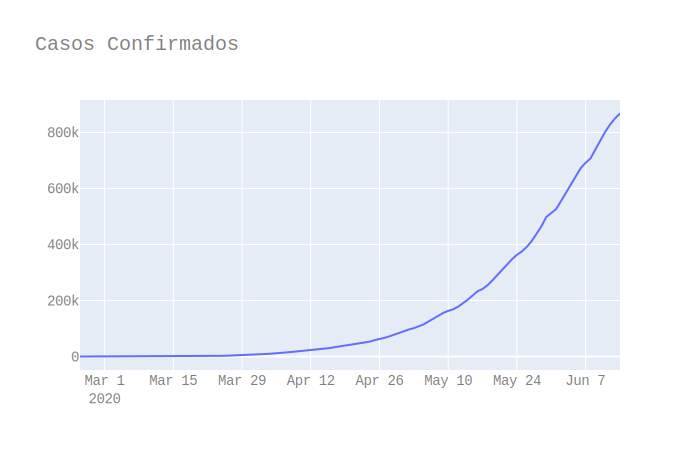

In [10]:
# Somar casos e mortes e juntar por dia
data_by_day = data.groupby(['date'])['cases','deaths'].agg('sum')

# Plot
layout = Layout(
    title="Casos Confirmados",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    )
)

fig = go.Figure(data=go.Line(x = data_by_day.index, y=data_by_day['cases']))

fig['layout'].update(layout)

fig.show()



Por conseguinte, realizou-se também o gráfico que demonstra o aumento do nº de óbitos durante este período.

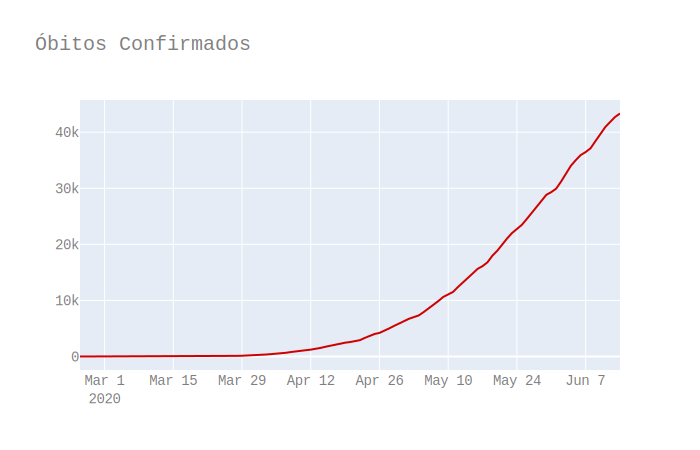

In [11]:
# Plot
layout = Layout(
    title="Óbitos Confirmados",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    )
)

fig = go.Figure(data=go.Line(x = data_by_day.index, y=data_by_day['deaths'], line_color='#cf0000'))

fig['layout'].update(layout)

fig.show()

Averíguamos agora através de gráficos de barras, qual tem sido o aumento diário de casos positivos e de óbitos no país.

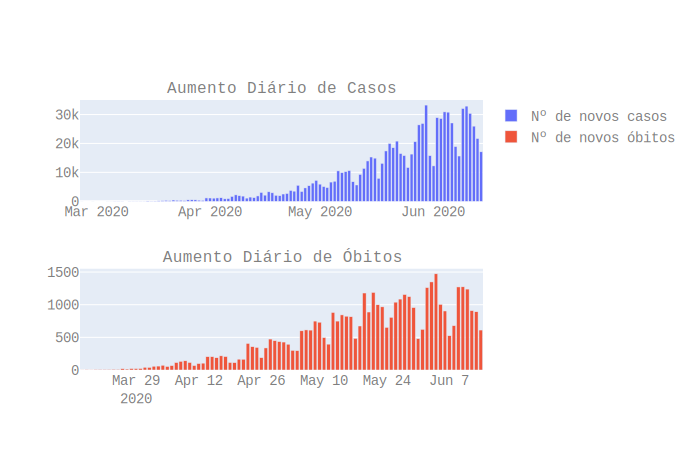

In [12]:
# Cálculo da taxa diária de casos e mortes
data_today = data_by_day
data_before = data_by_day.shift(1)

data_growth_rate = data_today - data_before
data_growth_rate = data_growth_rate.dropna()

cases_rate = data_growth_rate['cases'][data_growth_rate['cases']>0]
deaths_rate = data_growth_rate['deaths'][data_growth_rate['deaths']>0]

# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    )
)

fig = make_subplots(rows=2, cols=1
                    , subplot_titles=('Aumento Diário de Casos'
                                      , 'Aumento Diário de Óbitos'))

fig.append_trace(Bar(
    x=cases_rate.index,
    y=cases_rate,
    name='Nº de novos casos'
), row=1, col=1)

fig.append_trace(Bar(
    x=deaths_rate.index,
    y=deaths_rate,
    name='Nº de novos óbitos'
), row=2, col=1)

fig['layout'].update(layout)

fig.show()

Conseguimos ver que quanto ao gráfico da taxa de novos casos, até recentemente continua a aumentar o recorde diário de casos. Isto pode indicar vários fatores, nomeadamente o aumento da realização de testes.

Quanto ao gráfico da taxa de novos óbitos, é normal que acompanhe a tendência do primeiro. Pois quantas mais pessoas ficam infetadas, mais o nº diário de óbitos irá aumentar.

Na computação seguinte é investigada a divisão dos dados por estados, em termos de casos e óbitos.

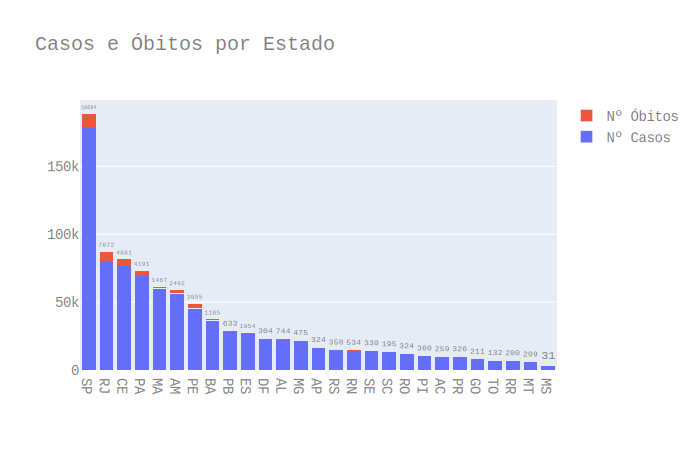

In [13]:
# Data mais recente do dataset
last_date = data['date'].tail(1).item()

# Casos e mortes por estado, para a última data do dataset
data_by_state = data[['cases','deaths']][data['date']==last_date].groupby(data['state']).sum().sort_values(by = 'cases', ascending=False)

# Plot
layout = Layout(
    title="Casos e Óbitos por Estado",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    height=600
)

fig = go.Figure(data=[
    
    go.Bar(name='Nº Casos'
           , x=data_by_state.index
           , y=data_by_state['cases']
           ),
    
    go.Bar(name='Nº Óbitos'
           , x=data_by_state.index
           , y=data_by_state['deaths']
           , text=data_by_state['deaths']
           , textposition='outside')
])

fig.update_layout(barmode='stack')
fig['layout'].update(layout)

fig.show()

O gráfico de barras é feito de forma a que no topo de cada barra, tenha uma *label* com o nº de óbitos, para uma melhor visualização.

Como podemos ver, atualmente os 3 estados com maior nº de infetados são São Paulo, Rio de Janeiro e Ceará. Estes também concentram entre si, como é natural, o maior nº de mortes do Brasil.

Depois de visualizarmos o efeito do vírus em diferentes aspetos, em seguida calculámos a sua taxa de letalidade nos infetados. Este dado é conseguido através da seguinte expressão:

$$
\textrm{Taxa de letalidade} =  \frac{\sum \textrm{óbitos}}{\sum \textrm{casos}}
$$

In [14]:
# Cálculo da taxa de letalidade
rate = sum(data_growth_rate['deaths'])/sum(data_growth_rate['cases'])

print("Taxa de letalidade no dia",last_date,": {0:.2f}%".format(rate*100))

Taxa de letalidade no dia 2020-06-14 : 4.99%
